In [19]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit

In [20]:
@parameters x, t
@variables A(..), B(..), dA(..), dB(..), gamma, gamma3, c, omega
r1 = @rule cos(~x)^3 => 0.75 * cos(~x) + 0.25 * cos(3 * ~x)
r2 = @rule sin(~x)^3 => 0.75 * sin(~x) - 0.25 * sin(3 * ~x)
r3 = @rule cos(~x)^2 => 1 - sin(~x)^2
r4 = @rule sin(~x)^2 => 1 - cos(~x)^2


xleft::Float64 = 0.0
xright::Float64 = 1.0
N = 1000
order = 2
stepx = (xright-xleft)/N
grid = collect(xleft:stepx:xright)

u = A(x) * sin(omega*t) + B(x) * cos(omega*t)
Dx = Differential(x)
Dt = Differential(t)
y = Dt(Dt(u)) - c*c*Dx(Dx(u)) + gamma*Dt(u) + gamma3*Dt(u)*Dt(u)*Dt(u)
y_exp = expand_derivatives(y)

y_exp = simplify(expand(y_exp), RuleSet([r1, r2, r3, r4]))
y_exp = expand(y_exp)
y_exp = simplify(y_exp, RuleSet([r1, r2, r3, r4]))

sin_coeff = -Symbolics.coeff(y_exp, sin(omega*t))
cos_coeff = -Symbolics.coeff(y_exp, cos(omega*t))

sin_sol = Symbolics.solve_for(sin_coeff ~ 0, Differential(x)(Differential(x)(A(x))))
println("Sin:")
println("Sin coeff: ", sin_coeff)
println("Axx = ", sin_sol)

fA = Symbolics.build_function(sin_sol, A(x), B(x), gamma, gamma3, omega, c; expression=Val{false})


cos_sol = Symbolics.solve_for(cos_coeff ~ 0, Differential(x)(Differential(x)(B(x))))
println("Cos:")
println("Cos coeff: ", cos_coeff)
println("Bxx = ", cos_sol)

fB = Symbolics.build_function(cos_sol, A(x), B(x), gamma, gamma3, omega, c; expression=Val{false})

eqs = [
    Dx(A) ~ dA
    Dx(dA) ~ sin_sol
    Dx(B) ~ dB 
    Dx(dB) ~ cos_sol - 1000/c^2
    ]

bcs = [
    A(xleft) ~ 0,
    dA(xleft) ~ 0,
    B(xright) ~ 0,
    dB(xright) ~ 0
]


@named bvp_sys = PDESystem(eqs, bcs, [x ∈ Interval(xleft, xright)], [x], [A, B, dA, dB])
discretization = MOLFiniteDifference([x=>grid], approx_order=order)

Sin:
Sin coeff: (c^2)*Differential(x)(Differential(x)(A(x))) + gamma*omega*B(x) + (omega^2)*A(x) + 0.75gamma3*(omega^3)*(A(x)^2)*B(x) + 0.75gamma3*(omega^3)*(B(x)^3)
Axx = (gamma*omega*B(x) + (omega^2)*A(x) + 0.75gamma3*(omega^3)*(A(x)^2)*B(x) + 0.75gamma3*(omega^3)*(B(x)^3)) / (-(c^2))
Cos:
Cos coeff: (c^2)*Differential(x)(Differential(x)(B(x))) - gamma*omega*A(x) + (omega^2)*B(x) - 0.75gamma3*(omega^3)*(A(x)^3) - 0.75gamma3*(omega^3)*A(x)*(B(x)^2)
Bxx = (-gamma*omega*A(x) + (omega^2)*B(x) - 0.75gamma3*(omega^3)*(A(x)^3) - 0.75gamma3*(omega^3)*A(x)*(B(x)^2)) / (-(c^2))


MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Vector{Float64}}(x => [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009  …  0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.0]), nothing, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Any[], Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}())

In [21]:
# set source function
src(x) = 1000. # obtain u(x) > 1 for [u(x)}^3 to be large in size to be important in the non-linearity

# set right-hand side
function F!(u, p)
    (;c, gamma, gamma3, omd) = p
    A = u[1]; dA = u[2]; B = u[3]; dB = u[4];
    [
        dA
        fA(A, B, gamma, gamma3, omd, c)
        dB
        fB(A, B, gamma, gamma3, omd, c) - 1000
    ]
end

F! (generic function with 1 method)

In [22]:
u0 = [0.0; 0.0; 0.0; 0.0]
xspan = (0.0, 100.0)
prob = ODEProblem(F!, u0, xspan)

LoadError: All methods for the model function `f` had too few arguments. For example,
an ODEProblem `f` must define either `f(u,p,t)` or `f(du,u,p,t)`. This error
can be thrown if you define an ODE model for example as `f(u,t)`. The parameters
`p` are not optional in the definition of `f`! For more information on the required
number of arguments for the function you were defining, consult the documentation
for the `SciMLProblem` or `SciMLFunction` type that was being constructed.

For example, here is the no parameter Lorenz equation. The two valid versions
are out of place:

```julia
function lorenz(u,p,t)
  du1 = 10.0*(u[2]-u[1])
  du2 = u[1]*(28.0-u[3]) - u[2]
  du3 = u[1]*u[2] - 8/3*u[3]
  [du1,du2,du3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz,u0,tspan)
```

and in-place:

```julia
function lorenz!(du,u,p,t)
  du[1] = 10.0*(u[2]-u[1])
  du[2] = u[1]*(28.0-u[3]) - u[2]
  du[3] = u[1]*u[2] - 8/3*u[3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz!,u0,tspan)
```

Offending function: [31m[1mf[22m[39m
Methods:
# 1 method for generic function "F!" from [36mMain[39m:
 [1] F!([90mu[39m, [90mp[39m)
[90m     @[39m [90m[4mIn[21]:5[24m[39m


In [23]:
par = (c = 3, gamma = 0.5, gamma3 = 0.5, omd = 2*pi*7)
u0 = zeros(4)
prob = BifurcationProblem(F!, u0, par, (@optic _.gamma));

In [24]:
br = continuation(prob, PALC(), ContinuationPar(p_min = 0.0, p_max = 30.0), bothside = true)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 223
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter gamma starts at 0.0, ends at 30.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at gamma ≈ +0.00000000,                                                                     step =   0
- #  2, endpoint at gamma ≈ +30.00000000,                                                                     step = 222


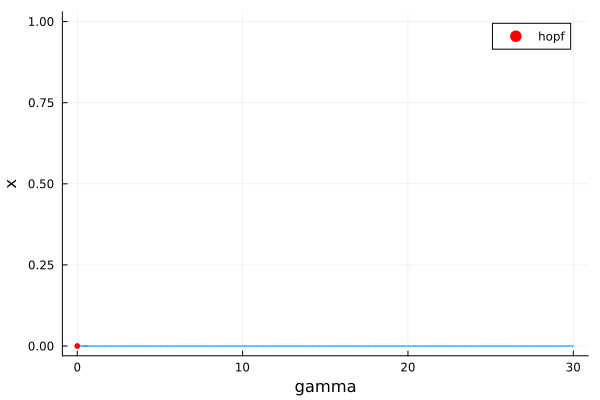

In [18]:
plot(br)